System info

In [1]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [2]:
!nvidia-smi

Mon Jan 10 03:08:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    63W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from timeit import default_timer as timer
from sklearn.model_selection import ParameterGrid

GPU version

In [4]:
import torch

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32


THREADS_PER_BLOCK = 64
BLOCKS_PER_GRID = 16


@cuda.jit
def breed_kernel(rng_states, new_pop, current_pop, parents_indices, n_ind, n_parents, n_genes, mut_proba, mut_mean, mut_var):
  
  index = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x  # == cuda.grid(1)
  stride = cuda.blockDim.x * cuda.gridDim.x  # == cuda.gridsize(1)

  for i in range(index, n_ind, stride): # for each new individual

    parent1_idx = parents_indices[i % n_parents]
    parent2_idx = parents_indices[(i + 1) % n_parents]

    # crossing-over begins

    crossover_point = int(xoroshiro128p_uniform_float32(rng_states, index) * n_genes)
    for k in range(n_genes):
      # crossover_point can be 0, in that case the 2nd parent will be pushed to the new generation, which is good
      if k < crossover_point:
        new_pop[i, k] = current_pop[parent1_idx, k]
      else:
        new_pop[i, k] = current_pop[parent2_idx, k]

    # crossing-over ends


    # mutation begins

    if xoroshiro128p_uniform_float32(rng_states, index) < mut_proba:
      mutation_point = int(xoroshiro128p_uniform_float32(rng_states, index) * n_genes)

      delta = mut_var * xoroshiro128p_uniform_float32(rng_states, index)
      mut = mut_mean
      if xoroshiro128p_uniform_float32(rng_states, index) < 0.5:
        mut += delta
      else:
        mut -= delta

      if xoroshiro128p_uniform_float32(rng_states, index) < 0.5:
        new_pop[i, mutation_point] += mut
      else:
        new_pop[i, mutation_point] -= mut
      
    # mutation ends


class GeneticAlgorithmGPU:

  def __init__(self, 
               points_x: np.ndarray, 
               points_y: np.ndarray, 
               n_genes: int, 
               n_ind, 
               n_parents, 
               n_max_gen, 
               mut_proba = 0.5, 
               mut_mean = 0, 
               mut_var = 1, 
               desired_fitness_value = None):
    """
    points_x: shape = (n_points,)
    points_y: shape = (n_points,)
    """
    self._n_genes = n_genes  # genes count
    self._n_parents = n_parents  # == len(self._parents_indices)
    self._n_ind = n_ind  # == len(self._new_pop) == len(self._current_pop)

    points_x_powers = np.vstack([points_x ** i for i in range(self._n_genes)])  # shape = (n_genes, n_points)

    self._points_x_powers_torch = torch.from_numpy(points_x_powers).cuda()
    self._points_y_torch = torch.from_numpy(points_y).cuda()
  
    self._current_pop = cuda.to_device(np.random.uniform(low=-1.0, high=1.0, size=(self._n_ind, self._n_genes)))
    self._current_pop_torch = torch.as_tensor(self._current_pop, device="cuda")

    self._new_pop = cuda.to_device(np.empty(shape=(self._n_ind, self._n_genes)))
    self._new_pop_torch = torch.as_tensor(self._new_pop, device="cuda")

    self._parents_indices = None

    self._current_fitnesses_torch = None
    self._best_fitness_value_torch = None
    self._desired_fitness_value_torch = torch.as_tensor(float(desired_fitness_value), device="cuda") if desired_fitness_value is not None else None
    
    self._n_max_gen = n_max_gen
    self._mut_proba = mut_proba
    self._mut_mean = mut_mean
    self._mut_var = mut_var

    self.best_solution_ = None
    self.elapsed_time_ = None

    self._rng_states = create_xoroshiro128p_states(THREADS_PER_BLOCK * BLOCKS_PER_GRID, seed=time.time())
    
  def _calc_fitnesses(self):  # on a current pop
    f_approx_matrix = torch.matmul(self._current_pop_torch, self._points_x_powers_torch)  # shape = (n_ind, n_points)
    self._current_fitnesses_torch = torch.linalg.norm(f_approx_matrix - self._points_y_torch, dim=-1)  # shape = (n_ind,)
  
  def _pick_parents(self):  # on a current pop
    elems_plus_indices = torch.topk(self._current_fitnesses_torch, self._n_parents, largest=False)
    self._parents_indices = cuda.as_cuda_array(elems_plus_indices[-1])

  def fit(self):

    self.elapsed_time_ = 0

    start_time = timer()

    self._calc_fitnesses()
    self._best_fitness_value_torch = self._current_fitnesses_torch[0]
    self._pick_parents()

    self.elapsed_time_ += (timer() - start_time)

    for epoch in range(self._n_max_gen):
      # print(f"Epoch #{epoch + 1}")

      if self._desired_fitness_value_torch is not None:
        if self._best_fitness_value_torch < self._desired_fitness_value_torch:
          print(f"Best fitness value {self._best_fitness_value_torch.item()} became less than desired value {self._desired_fitness_value_torch.item()} at the epoch #{epoch + 1}")
          break

      
      start_time = timer()

      breed_kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK](self._rng_states,
                                                       self._new_pop, 
                                                       self._current_pop, 
                                                       self._parents_indices, 
                                                       self._n_ind, 
                                                       self._n_parents, 
                                                       self._n_genes, 
                                                       self._mut_proba, 
                                                       self._mut_mean, 
                                                       self._mut_var)

      self._current_pop.copy_to_device(self._new_pop)

      self._calc_fitnesses()
      self._best_fitness_value_torch = self._current_fitnesses_torch[0]
      self._pick_parents()

      self.elapsed_time_ += (timer() - start_time)

    self.best_solution_ = self._current_pop[self._parents_indices[0]].copy_to_host()
    self.best_fitness_value_ = self._best_fitness_value_torch.item()


In [5]:
def breed_cpu(new_pop, current_pop, parents_indices, n_ind, n_parents, n_genes, mut_proba, mut_mean, mut_var):

  for i in range(n_ind): # for each new individual

    parent1_idx = parents_indices[i % n_parents]
    parent2_idx = parents_indices[(i + 1) % n_parents]

    # crossing-over begins

    crossover_point = np.random.randint(low=0, high=n_genes)

    # crossover_point can be 0, in that case the 2nd parent will be pushed to the new generation, which is good
    new_pop[i, :crossover_point] = current_pop[parent1_idx, :crossover_point]
    new_pop[i, crossover_point:] = current_pop[parent2_idx, crossover_point:]

    # crossing-over ends


    # mutation begins

    if np.random.uniform() < mut_proba:
      mutation_point = np.random.randint(low=0, high=n_genes)

      delta = mut_var * np.random.uniform()
      mut = mut_mean
      if np.random.uniform() < 0.5:
        mut += delta
      else:
        mut -= delta

      if np.random.uniform() < 0.5:
        new_pop[i, mutation_point] += mut
      else:
        new_pop[i, mutation_point] -= mut
      
    # mutation ends


class GeneticAlgorithmCPU:

  def __init__(self, 
               points_x: np.ndarray, 
               points_y: np.ndarray, 
               n_genes: int, 
               n_ind, 
               n_parents, 
               n_max_gen, 
               mut_proba = 0.5, 
               mut_mean = 0, 
               mut_var = 1, 
               desired_fitness_value = None):
    """
    points_x: shape = (n_points,)
    points_y: shape = (n_points,)
    """
    self._n_genes = n_genes  # genes count
    self._n_parents = n_parents  # == len(self._parents_indices)
    self._n_ind = n_ind  # == len(self._new_pop) == len(self._current_pop)

    points_x_powers = np.vstack([points_x ** i for i in range(self._n_genes)])  # shape = (n_genes, n_points)

    self._points_x_powers = points_x_powers
    self._points_y = points_y
  
    self._current_pop = np.random.uniform(low=-1.0, high=1.0, size=(self._n_ind, self._n_genes))

    self._new_pop = np.empty(shape=(self._n_ind, self._n_genes))

    self._parents_indices = None

    self._current_fitnesses = None
    self._best_fitness_value = None
    self._desired_fitness_value = float(desired_fitness_value) if desired_fitness_value is not None else None
    
    self._n_max_gen = n_max_gen
    self._mut_proba = mut_proba
    self._mut_mean = mut_mean
    self._mut_var = mut_var

    self.best_solution_ = None
    self.elapsed_time_ = None
    
  def _calc_fitnesses(self):  # on a current pop
    f_approx_matrix = np.matmul(self._current_pop, self._points_x_powers)  # shape = (n_ind, n_points)
    self._current_fitnesses = np.linalg.norm(f_approx_matrix - self._points_y, axis=-1)  # shape = (n_ind,)
  
  def _pick_parents(self):  # on a current pop
    self._parents_indices = np.argsort(self._current_fitnesses)[:self._n_parents]

  def fit(self):

    self.elapsed_time_ = 0

    start_time = timer()

    self._calc_fitnesses()
    self._best_fitness_value = self._current_fitnesses[0]
    self._pick_parents()

    self.elapsed_time_ += (timer() - start_time)

    for epoch in range(self._n_max_gen):
      # print(f"Epoch #{epoch + 1}")

      if self._desired_fitness_value is not None:
        if self._best_fitness_value < self._desired_fitness_value:
          print(f"Best fitness value {self._best_fitness_value} became less than desired value {self._desired_fitness_value} at the epoch #{epoch + 1}")
          break

      start_time = timer()

      breed_cpu(self._new_pop, 
                self._current_pop, 
                self._parents_indices, 
                self._n_ind, 
                self._n_parents, 
                self._n_genes, 
                self._mut_proba, 
                self._mut_mean, 
                self._mut_var)
      
      self._current_pop[...] = self._new_pop

      self._calc_fitnesses()
      self._best_fitness_value = self._current_fitnesses[0]
      self._pick_parents()

      self.elapsed_time_ += (timer() - start_time)

    self.best_solution_ = self._current_pop[self._parents_indices[0]]
    self.best_fitness_value_ = self._best_fitness_value


Experiments

In [6]:
interval = (0, 2*np.pi)
func = np.sin

params_dict = {
    'n_points': [100, 500, 1000],
    'n_genes': [5],
    'n_ind': [1000, 1500, 2000],
    'n_max_gen': [100, 500, 1000]
}

parameter_grid = list(ParameterGrid(params_dict))

coefs_list_gpu = []
coefs_list_cpu = []

df = pd.DataFrame(columns=('Points count', 
                           'Genes (x-powers) count', 
                           'Individuals count', 
                           'Epochs count', 
                           'CPU time', 
                           'GPU time', 
                           'Accel (CPUt/GPUt)', 
                           'CPU min err', 
                           'GPU min err'))

In [7]:
for i, setup in enumerate(parameter_grid):
  print(f'RUNNING SETUP #{i}: {setup}')

  xs = np.linspace(*interval, setup['n_points'])
  ys = func(xs)

  ga_gpu = GeneticAlgorithmGPU(points_x=xs, 
                               points_y=ys, 
                               n_genes=setup['n_genes'], 
                               n_ind=setup['n_ind'], 
                               n_parents=setup['n_ind'] // 15, 
                               n_max_gen=setup['n_max_gen'],
                              #  mut_mean = 1,
                              #  mut_var=4
                               )

  ga_cpu = GeneticAlgorithmCPU(points_x=xs, 
                               points_y=ys, 
                               n_genes=setup['n_genes'], 
                               n_ind=setup['n_ind'], 
                               n_parents=setup['n_ind'] // 15, 
                               n_max_gen=setup['n_max_gen'],
                              #  mut_mean = 1,
                              #  mut_var=4
                               )
  
  ga_gpu.fit()
  ga_cpu.fit()

  coefs_list_gpu.append(ga_gpu.best_solution_)
  coefs_list_cpu.append(ga_cpu.best_solution_)

  df.loc[i] = [setup['n_points'], 
               setup['n_genes'], 
               setup['n_ind'], 
               setup['n_max_gen'], 
               ga_cpu.elapsed_time_, 
               ga_gpu.elapsed_time_, 
               ga_cpu.elapsed_time_ / ga_gpu.elapsed_time_, 
               ga_cpu.best_fitness_value_,
               ga_gpu.best_fitness_value_]


RUNNING SETUP #0: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 100, 'n_points': 100}
RUNNING SETUP #1: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 100, 'n_points': 500}
RUNNING SETUP #2: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 100, 'n_points': 1000}
RUNNING SETUP #3: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 500, 'n_points': 100}
RUNNING SETUP #4: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 500, 'n_points': 500}
RUNNING SETUP #5: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 500, 'n_points': 1000}
RUNNING SETUP #6: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 1000, 'n_points': 100}
RUNNING SETUP #7: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 1000, 'n_points': 500}
RUNNING SETUP #8: {'n_genes': 5, 'n_ind': 1000, 'n_max_gen': 1000, 'n_points': 1000}
RUNNING SETUP #9: {'n_genes': 5, 'n_ind': 1500, 'n_max_gen': 100, 'n_points': 100}
RUNNING SETUP #10: {'n_genes': 5, 'n_ind': 1500, 'n_max_gen': 100, 'n_points': 500}
RUNNING SETUP #11: {'n_genes': 5, 'n_ind': 1500, 'n_max_gen': 100, 'n_points': 1

In [8]:
df

,Points count,Genes (x-powers) count,Individuals count,Epochs count,CPU time,GPU time,Accel (CPUt/GPUt),CPU min err,GPU min err
0,100.0,5.0,1000.0,100.0,3.076527,0.589349,5.220210,477.588829,20.008879
1,500.0,5.0,1000.0,100.0,3.304974,0.169656,19.480397,10.893776,9.413662
2,1000.0,5.0,1000.0,100.0,3.499599,0.174744,20.026961,2005.996611,9.290858
3,100.0,5.0,1000.0,500.0,15.509701,0.686715,22.585357,497.567726,24.910210
4,500.0,5.0,1000.0,500.0,16.476109,0.709600,23.218870,62.714115,6.131370
5,1000.0,5.0,1000.0,500.0,17.752024,0.709042,25.036623,5.229473,8.925648
6,100.0,5.0,1000.0,1000.0,31.141385,1.344807,23.156765,5.564473,2253.818247
7,500.0,5.0,1000.0,1000.0,32.853680,1.401689,23.438644,3831.207806,5199.620391
8,1000.0,5.0,1000.0,1000.0,35.886590,1.358053,26.425020,11.823587,5.961982
9,100.0,5.0,1500.0,100.0,4.708386,0.160673,29.304151,7.841041,0.815907


In [9]:
print(df.to_markdown())

|    |   Points count |   Genes (x-powers) count |   Individuals count |   Epochs count |   CPU time |   GPU time |   Accel (CPUt/GPUt) |   CPU min err |   GPU min err |
|---:|---------------:|-------------------------:|--------------------:|---------------:|-----------:|-----------:|--------------------:|--------------:|--------------:|
|  0 |            100 |                        5 |                1000 |            100 |    3.07653 |   0.589349 |             5.22021 |     477.589   |     20.0089   |
|  1 |            500 |                        5 |                1000 |            100 |    3.30497 |   0.169656 |            19.4804  |      10.8938  |      9.41366  |
|  2 |           1000 |                        5 |                1000 |            100 |    3.4996  |   0.174744 |            20.027   |    2006       |      9.29086  |
|  3 |            100 |                        5 |                1000 |            500 |   15.5097  |   0.686715 |            22.5854  |     497.568 

In [10]:
experiment_to_visualize = df.idxmin()['GPU min err']
experiment_to_visualize

9

In [11]:
# experiment_to_visualize = 20

In [12]:
setup_to_visualize = parameter_grid[experiment_to_visualize]
setup_to_visualize

{'n_genes': 5, 'n_ind': 1500, 'n_max_gen': 100, 'n_points': 100}

In [13]:
def get_pred_ys(xs, coefs):
  return np.matmul(coefs.reshape(1, -1), np.vstack([xs ** i for i in range(len(coefs))])).reshape(-1)

In [14]:
xs = np.linspace(*interval, setup_to_visualize['n_points'])
ys_true = func(xs)
ys_approx = get_pred_ys(xs, coefs_list_gpu[experiment_to_visualize])

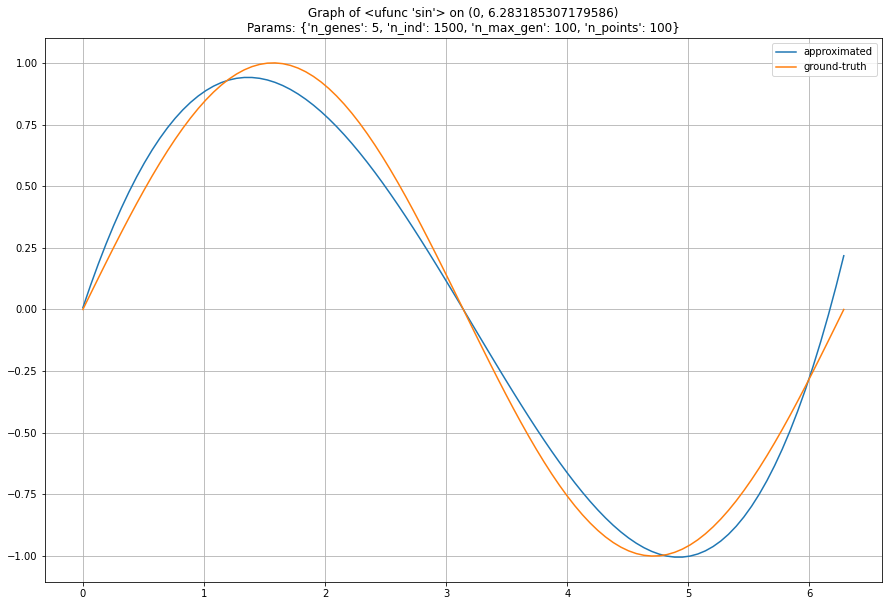

In [15]:
plt.figure(figsize=(15, 10))
plt.title(f'Graph of {func} on {interval}\nParams: {setup_to_visualize}')
plt.plot(xs, ys_approx, label='approximated')
plt.plot(xs, ys_true, label='ground-truth')
plt.legend()
plt.grid()